In [1]:
import os.path
import time
from six.moves import xrange
import tensorflow as tf
import input_data
import c3d_model_transfer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Basic model parameters as external flags.
flags = tf.app.flags
gpu_num = 1
flags.DEFINE_integer('batch_size', 1 , 'Batch size.')
FLAGS = flags.FLAGS

# Load data

Loading a video clip from \Data\Remove0\v_Remove0_e3_0...


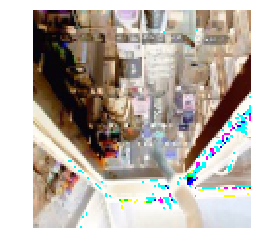

In [3]:
test_list_file = 'list/myTest.list'
start_pos = 0

X, y, _, _, test_len = \
            input_data.read_clip_and_label(
                    test_list_file,
                    FLAGS.batch_size * gpu_num,
                    start_pos=start_pos,
					num_frames_per_clip=c3d_model_transfer.NUM_FRAMES_PER_CLIP,
                    crop_size=c3d_model_transfer.CROP_SIZE,
                    )
mean_images = np.load('crop_mean.npy').reshape([16, c3d_model_transfer.CROP_SIZE, c3d_model_transfer.CROP_SIZE, 3])

plt.imshow(X[0, 0] + mean_images[0])
plt.axis('off')
plt.show()

# Load trained model

In [4]:
def placeholder_inputs(batch_size):
  images_placeholder = tf.placeholder(tf.float32, shape=(batch_size,
                                                         c3d_model_transfer.NUM_FRAMES_PER_CLIP,
                                                         c3d_model_transfer.CROP_SIZE,
                                                         c3d_model_transfer.CROP_SIZE,
                                                         c3d_model_transfer.CHANNELS))
  labels_placeholder = tf.placeholder(tf.int64, shape=(batch_size))
  return images_placeholder, labels_placeholder

def _variable_on_cpu(name, shape, initializer):
  # with tf.device('/cpu:%d' % cpu_id):
  with tf.device('/cpu:0'):
    var = tf.get_variable(name, shape, initializer=initializer)
  return var

def _variable_with_weight_decay(name, shape, stddev, wd):
  var = _variable_on_cpu(name, shape, tf.truncated_normal_initializer(stddev=stddev))
  if wd is not None:
    weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)
  return var

In [5]:
tf.reset_default_graph()

# Get the sets of images and labels for training, validation, and
images_placeholder, labels_placeholder = placeholder_inputs(FLAGS.batch_size * gpu_num)
with tf.variable_scope('var_name') as var_scope:
    weights = {
            'wc1': _variable_with_weight_decay('wc1', [3, 3, 3, 3, 64], 0.0, 0.00),
            'wc2': _variable_with_weight_decay('wc2', [3, 3, 3, 64, 128], 0.0, 0.00),
            'wc3a': _variable_with_weight_decay('wc3a', [3, 3, 3, 128, 256], 0.0, 0.00),
            'wc3b': _variable_with_weight_decay('wc3b', [3, 3, 3, 256, 256], 0.0, 0.00),
            'wc4a': _variable_with_weight_decay('wc4a', [3, 3, 3, 256, 512], 0.0, 0.00),
            'wc4b': _variable_with_weight_decay('wc4b', [3, 3, 3, 512, 512], 0.0, 0.00),
            'wc5a': _variable_with_weight_decay('wc5a', [3, 3, 3, 512, 512], 0.0, 0.00),
            'wc5b': _variable_with_weight_decay('wc5b', [3, 3, 3, 512, 512], 0.0, 0.00),
            'wd1': _variable_with_weight_decay('wd1', [8192, 4096], 0.0, 0.00),
            'wd2': _variable_with_weight_decay('wd2', [4096, 4096], 0.0, 0.00)}
    biases = {
            'bc1': _variable_with_weight_decay('bc1', [64], 0.0, 0.0),
            'bc2': _variable_with_weight_decay('bc2', [128], 0.0, 0.0),
            'bc3a': _variable_with_weight_decay('bc3a', [256], 0.0, 0.0),
            'bc3b': _variable_with_weight_decay('bc3b', [256], 0.0, 0.0),
            'bc4a': _variable_with_weight_decay('bc4a', [512], 0.0, 0.0),
            'bc4b': _variable_with_weight_decay('bc4b', [512], 0.0, 0.0),
            'bc5a': _variable_with_weight_decay('bc5a', [512], 0.0, 0.0),
            'bc5b': _variable_with_weight_decay('bc5b', [512], 0.0, 0.0),
            'bd1': _variable_with_weight_decay('bd1', [4096], 0.0, 0.0),
            'bd2': _variable_with_weight_decay('bd2', [4096], 0.0, 0.0)}
    logits = []

for gpu_index in range(0, gpu_num):
    with tf.device('/gpu:%d' % gpu_index):
      myWeights = _variable_with_weight_decay('wout', [4096, c3d_model_transfer.NUM_CLASSES], 0.0, 0.00)
      myBiases = _variable_with_weight_decay('bout', [c3d_model_transfer.NUM_CLASSES], 0.0, 0.0)
      logit = c3d_model_transfer.inference_c3d(images_placeholder[gpu_index * FLAGS.batch_size:(gpu_index + 1) * FLAGS.batch_size,:,:,:,:], 0.6, FLAGS.batch_size, weights, biases, myWeights, myBiases)
      logits.append(logit)
    norm_score = tf.nn.softmax(logits)

In [6]:
with open('models/checkpoint','r') as model_list:
    model_name = model_list.readline()
model_name = model_name.split('"', 2)[1]
model_name = 'models/' + model_name
    
saver = tf.train.Saver()
init = tf.initialize_all_variables()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
sess.run(init)
saver.restore(sess, model_name)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from models/my_c3d_model-599


In [7]:
predict_score = norm_score.eval(
            session=sess,
            feed_dict={images_placeholder: X}
            )
top1_predicted_label = np.argmax(predict_score[0], axis=1)

# Saliency map

In [8]:
def compute_saliency_maps(X, y, norm_score, images_placeholder, labels_placeholder):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input videos, numpy array of shape (N, D, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, D, H, W) giving the saliency maps for the
    input images.
    """
    correct_scores = tf.gather_nd(norm_score[0],
                              tf.stack((tf.range(X.shape[0], dtype='int32'), tf.to_int32(labels_placeholder)), axis=1))
    grads = tf.gradients(correct_scores, images_placeholder)
    gradients = sess.run(grads, {images_placeholder: X, labels_placeholder: y})
    
    saliency= np.amax(np.abs(gradients[0]), axis=-1)
    
    return saliency

In [9]:
def show_saliency_maps(X, y, norm_score, images_placeholder, labels_placeholder):
    saliency = compute_saliency_maps(X, y, norm_score, images_placeholder, labels_placeholder)

    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[0, i] + mean_images[i])
        plt.axis('off')
        
        plt.subplot(2, 5, 5 + i + 1)
        plt.imshow(saliency[0, i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()
    return saliency

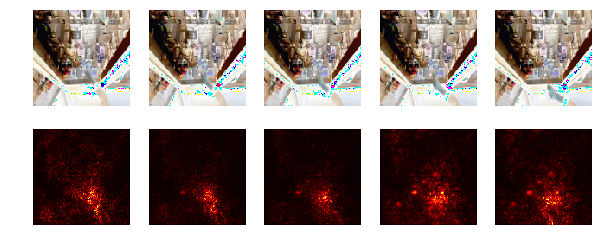

In [10]:
saliency = show_saliency_maps(X, y, norm_score, images_placeholder, labels_placeholder)

## Confusion matrix

Read predictions and generate confusion array

In [11]:
conf_arr = np.zeros((4,4))
with open('predict_ret.txt','r') as prediction_result:
    for line in prediction_result:
        this_line = prediction_result.readline()
        true_label = int(this_line.split(',', 5)[0].replace('(',''))
        pred_label = int(this_line.split(',', 5)[3])
        conf_arr[true_label, pred_label] += 1
conf_arr.astype(int)

array([[56,  0,  0,  0],
       [ 0, 25,  0,  2],
       [ 1,  0, 45,  0],
       [ 0,  0,  0, 49]])

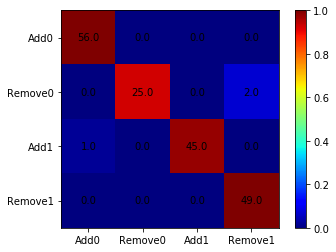

In [12]:
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
classe_labels = ['Add0', 'Remove0', 'Add1', 'Remove1']
plt.xticks(range(width), classe_labels)
plt.yticks(range(height), classe_labels)
plt.savefig('confusion_matrix.png', format='png')
plt.show()
plt.close()